In [1]:
#General libraries
import os, argparse
import pickle
import numpy as np

#Torch libraries
import torch 

#Custom libraries
from utils_ide import Train_val_split, Dynamics_Dataset, Test_Dynamics_Dataset
from utils_ide import fix_random_seeds,to_np
from source.ide_func import NNIDEF, NeuralIDE, NNIDEF_wODE, NeuralIDE_wODE
import source.kernels as kernels
from source.experiments import Full_experiment, IDE_spiral_experiment_no_adjoint
from torch.utils.data import SubsetRandomSampler

if torch.cuda.is_available():  
    device = "cuda:0" 
else:  
    device = "cpu"
    

parser = argparse.ArgumentParser(description='Neural IDE')
parser.add_argument('-root_path', metavar='DIR', default='/gpfs/ysm/project/dijk/eaz29',
                    help='path to dataset')
parser.add_argument('-dataset-name', default='stl10',
                    help='dataset name', choices=['acrobot_dataset'])

parser.add_argument('-j', '--workers', default=12, type=int, metavar='N',
                    help='number of data loading workers (default: 32)')
parser.add_argument('--epochs', default=5000, type=int, metavar='N',
                    help='number of total epochs to run')
parser.add_argument('-b', '--batch_size', default=20, type=int,
                    metavar='N',
                    help='mini-batch size (default: 256), this is the total '
                         'batch size of all GPUs on the current node when '
                         'using Data Parallel or Distributed Data Parallel')
parser.add_argument('--lr', '--learning-rate', default=1e-3, type=float,
                    metavar='LR', help='initial learning rate', dest='lr')
parser.add_argument('--wd', '--weight-decay', default=1e-3, type=float,
                    metavar='W', help='weight decay (default: 1e-3)',
                    dest='weight_decay')
parser.add_argument('--seed', default=None, type=int,
                    help='seed for initializing training. ')
parser.add_argument('--disable-cuda', action='store_true',
                    help='Disable CUDA')
parser.add_argument('--fp16-precision', action='store_true',
                    help='Whether or not to use 16-bit precision GPU training.')

parser.add_argument('--out_dim', default=128, type=int,
                    help='feature dimension (default: 128)')
parser.add_argument('--log-every-n-steps', default=100, type=int,
                    help='Log every n steps')
parser.add_argument('--temperature', default=0.07, type=float,
                    help='softmax temperature (default: 0.07)')
parser.add_argument('--n-views', default=2, type=int, metavar='N',
                    help='Number of views for contrastive learning training.')
parser.add_argument('--gpu-index', default=0, type=int, help='Gpu index.')
parser.add_argument('--model', default='simclr', choices=['simclr','lipschitz_simclr','vae','gan'], 
                    help='Models to be used')
parser.add_argument('--mode', default='train', choices=['train','evaluate'], 
                    help='Set to ''evaluate'' if inference is desired')
parser.add_argument('--training_split', default=0.25,type=float, 
                    help='Fraction of the samples that will be used for validation')
parser.add_argument('--resume_from_checkpoint', default=None, 
                    help='Give string to run number. Ex: "run12"')
parser.add_argument('--plot_freq', default=1, type=int,help='')
parser.add_argument('--experiment_name', default=None,help='')


_StoreAction(option_strings=['--experiment_name'], dest='experiment_name', nargs=None, const=None, default=None, type=None, choices=None, help='', metavar=None)

In [2]:
from source.solver import IDESolver_monoidal
import matplotlib.pyplot as plt
import pickle

In [3]:
torch.cuda.device_count()

1

In [4]:
if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"
device = torch.device(dev)

In [5]:
args = parser.parse_args("")
args.model='nide' #'simclr', 
args.mode='train'
#args.mode = 'evaluate'
args.dataset_name = 'ide_spiral'
args.seed = 1
args.batch_size = 5 #batch size 
args.experiment_name = 'ide_spiral_nide_1'
args.plot_freq = 1
args.device = device
args.num_dim_plot = 2
args.lr = 1e-3
args.min_lr=1e-12
args.T_max = 51
args.plat_patience = 10
args.factor = 0.1
args.train_split = 0.2
# args.temperature=0.001
#args.lr_scheduler = 'ReduceLROnPlateau'
args.lr_scheduler = 'CosineAnnealingLR'
#args.resume_from_checkpoint = 'run149'
fix_random_seeds(args.seed)
args.number_MC_samplings = 1000
args.warmup = 11

In [7]:
t_max = 1 
t_min = 0
n_points = 20

index_np = np.arange(0, n_points, 1, dtype=int)
index_np = np.hstack(index_np[:, None])
times_np = np.linspace(t_min, t_max, num=n_points)
times_np = np.hstack([times_np[:, None]])
# print('times_np: ',times_np)

###########################################################
times = torch.from_numpy(times_np[:, :, None]).to(device)
times = times.flatten().float()
# print('times :',times)
###########################################################

In [8]:
Data = pickle.load(open( "50_IE_Spirals.pkl", "rb" ))
print(Data.shape)

torch.Size([500, 100, 2])


In [9]:
Data = Data - Data.mean(1,keepdim=True) #Normalization step
scaling_factor = to_np(Data).max()
print('scaling_factor: ',scaling_factor)

Data = Data/scaling_factor
if args.mode == 'train':
    Data = Data[:450,...]
else:
    Data = Data[450:,...]

scaling_factor:  0.915916


In [10]:
ids = np.tile(np.linspace(0,Data.shape[1]-1,num=n_points, dtype=np.int64),(Data.shape[1],1))

In [11]:
ids[0]

array([ 0,  5, 10, 15, 20, 26, 31, 36, 41, 46, 52, 57, 62, 67, 72, 78, 83,
       88, 93, 99])

In [12]:
Data = Data[:,ids[0],:]

In [13]:
Data.shape

torch.Size([450, 20, 2])

In [14]:
from torch import nn
class NN_feedforward(nn.Module):
    def __init__(self, in_dim, hid_dim,out_dim):
        super(NN_feedforward, self).__init__()

        self.lin1 = nn.Linear(in_dim, hid_dim)
        self.lin2 = nn.Linear(hid_dim, hid_dim)
        self.lin3 = nn.Linear(hid_dim, hid_dim)
        self.lin4 = nn.Linear(hid_dim, out_dim)
        self.ELU = nn.ELU(inplace=True)
        
        self.in_dim = in_dim

    def forward(self,y):
        y_in = y.to(args.device)
        
        h = self.ELU(self.lin1(y_in))
        h = self.ELU(self.lin2(h))
        h = self.ELU(self.lin3(h))
        out = self.lin4(h)
        
        return out

In [15]:
class Simple_NN(nn.Module):
    def __init__(self, in_dim, hid_dim,out_dim):
        super(Simple_NN, self).__init__()

        self.lin1 = nn.Linear(in_dim+1, hid_dim)
        self.lin2 = nn.Linear(hid_dim, hid_dim)
        self.lin3 = nn.Linear(hid_dim, hid_dim)
        self.lin4 = nn.Linear(hid_dim, out_dim)
        self.ELU = nn.ELU(inplace=True)
        
        self.in_dim = in_dim

    def forward(self,x,y):
        y = y.to(device)
        x = x.view(1,1).repeat(y.shape[0],1).to(device)
        
        y_in = torch.cat([x,y],-1)
        h = self.ELU(self.lin1(y_in))
        h = self.ELU(self.lin2(h))
        h = self.ELU(self.lin3(h))
        out = self.lin4(h)
        
        return out

In [16]:

n_steps = 10000 #number of iterations for training. default=3k epochs
print('Data.shape: ',Data.shape)


train_split = int(Data.shape[0]*args.train_split)

Dataset_train = Dynamics_Dataset(Data[:-train_split,...],times)
Dataset_val = Dynamics_Dataset(Data[-train_split:,...],times)
Dataset_all = Dynamics_Dataset(Data,times)


dataloaders = {'train': torch.utils.data.DataLoader(Dataset_train, batch_size = args.batch_size),
               'val': torch.utils.data.DataLoader(Dataset_val, batch_size = args.batch_size),
               'test': torch.utils.data.DataLoader(Dataset_all, batch_size = args.batch_size),
              }


nn_kernel = kernels.kernel_NN_nbatch(Data.shape[-1], Data.shape[-1],[64,128,256,512,256,128,64])
ker = nn_kernel.to(device)
F_func = NN_feedforward(2,256,2).to(device)
ode_func = Simple_NN(2,256,2).to(device)


kernel_type_nn = True
ode_nn = True


Data.shape:  torch.Size([450, 20, 2])


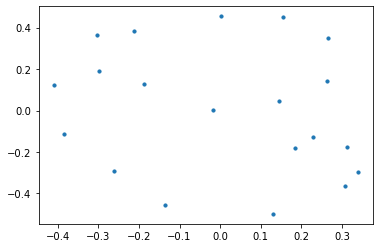

In [17]:
import matplotlib.pyplot as plt
Data_print = to_np(Data)
plt.scatter(Data_print[0,:,0],Data_print[0,:,1],label='Original Data',s=10)

In [18]:
kernels.flatten_kernel_parameters(ker).size()

torch.Size([345858])

In [19]:
kernels.flatten_F_parameters(F_func).size()

torch.Size([132866])

In [20]:
kernels.flatten_F_parameters(ode_func).size()

torch.Size([133122])

In [21]:
args.alpha = lambda x: torch.Tensor([0]).to(args.device)
args.beta = lambda x: x.to(args.device)

In [ ]:
IDE_spiral_experiment_no_adjoint(ker, F_func, ode_func, Data, 
                                dataloaders, times, ode_nn, 
                                 None, args
                                 )

path_to_experiment:  /gpfs/ysm/project/dijk/eaz29/nide/ide_spiral_nide_1
writer.log_dir:  /gpfs/ysm/project/dijk/eaz29/nide/ide_spiral_nide_1/run155
Epoch: 0


100%|██████████| 18/18 [00:10<00:00,  1.77it/s]



Best validation loss: 0.05277939803070492
Saving best model for epoch: 1

Epoch: 1


 24%|██▎       | 17/72 [00:26<01:37,  1.77s/it]/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 0
  warnings.warn(
 25%|██▌       | 18/72 [00:28<01:37,  1.80s/it]/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 0
  warnings.warn(
 26%|██▋       | 19/72 [00:30<01:36,  1.83s/it]/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 0
  warnings.warn(
 28%|██▊       | 20/72 [00:32<01:34,  1.82s/it]/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 0
  warnings.warn(
 29%|██▉       | 21/72 [00:34<01:32,  1.82s/it]/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 0
  warnings.warn(
 31%|███       | 22/72 [00:35<01:32,  1.85s/it]/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 0
  warnings.warn(
 32%|███▏      | 23/72 [00:37<01:31,  1.86s/it]/gpfs/ysm/home/eaz29/source/solver.py:211: User


Best validation loss: 0.04777537203497357
Saving best model for epoch: 2

Epoch: 2


  0%|          | 0/72 [00:00<?, ?it/s]/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 0
  warnings.warn(
  1%|▏         | 1/72 [00:01<02:10,  1.84s/it]/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 0
  warnings.warn(
  3%|▎         | 2/72 [00:03<02:08,  1.84s/it]/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 0
  warnings.warn(
  4%|▍         | 3/72 [00:05<02:03,  1.79s/it]/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 0
  warnings.warn(
  6%|▌         | 4/72 [00:07<01:58,  1.74s/it]/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 0
  warnings.warn(
  7%|▋         | 5/72 [00:08<01:54,  1.71s/it]/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 0
  warnings.warn(
  8%|▊         | 6/72 [00:10<01:51,  1.69s/it]/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error 

INFO: Early stopping counter 1 of 1000
Epoch: 3


  0%|          | 0/72 [00:00<?, ?it/s]/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 0
  warnings.warn(
  1%|▏         | 1/72 [00:01<02:00,  1.69s/it]/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 0
  warnings.warn(
  3%|▎         | 2/72 [00:03<02:00,  1.72s/it]/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 0
  warnings.warn(
  4%|▍         | 3/72 [00:05<01:56,  1.69s/it]/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 0
  warnings.warn(
  6%|▌         | 4/72 [00:06<01:53,  1.67s/it]/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 0
  warnings.warn(
  7%|▋         | 5/72 [00:08<01:51,  1.66s/it]/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 0
  warnings.warn(
  8%|▊         | 6/72 [00:10<01:49,  1.66s/it]/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error 


Best validation loss: 0.04682838006152047
Saving best model for epoch: 4

Epoch: 4


  0%|          | 0/72 [00:00<?, ?it/s]/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 0
  warnings.warn(
  1%|▏         | 1/72 [00:02<02:23,  2.03s/it]/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 0
  warnings.warn(
  3%|▎         | 2/72 [00:04<02:20,  2.01s/it]/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 0
  warnings.warn(
  4%|▍         | 3/72 [00:05<02:17,  1.99s/it]/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 0
  warnings.warn(
  6%|▌         | 4/72 [00:07<02:13,  1.97s/it]/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 0
  warnings.warn(
  7%|▋         | 5/72 [00:09<02:12,  1.97s/it]/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 0
  warnings.warn(
  8%|▊         | 6/72 [00:11<02:08,  1.95s/it]/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error 


Best validation loss: 0.04545773296720452
Saving best model for epoch: 5

Epoch: 5


  0%|          | 0/72 [00:00<?, ?it/s]/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 0
  warnings.warn(
  1%|▏         | 1/72 [00:02<02:39,  2.24s/it]/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 0
  warnings.warn(
  3%|▎         | 2/72 [00:04<02:28,  2.13s/it]/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 0
  warnings.warn(
  4%|▍         | 3/72 [00:06<02:23,  2.08s/it]/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 0
  warnings.warn(
/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 2
  warnings.warn(
  6%|▌         | 4/72 [00:08<02:21,  2.07s/it]/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 0
  warnings.warn(
/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 2
  warnings.warn(
  7%|▋         | 5/72 [00:10<02:17,  2.05s/it]/gpf

INFO: Early stopping counter 1 of 1000
Epoch: 6


  0%|          | 0/72 [00:00<?, ?it/s]/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 0
  warnings.warn(
  1%|▏         | 1/72 [00:02<02:43,  2.30s/it]/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 0
  warnings.warn(
  3%|▎         | 2/72 [00:04<02:22,  2.03s/it]/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 0
  warnings.warn(
/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 2
  warnings.warn(
  4%|▍         | 3/72 [00:06<02:21,  2.05s/it]/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 0
  warnings.warn(
/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 2
  warnings.warn(
  6%|▌         | 4/72 [00:08<02:22,  2.10s/it]/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 0
  warnings.warn(
/gpfs/ysm/home/eaz29/source/solver.py:211: UserWar


Best validation loss: 0.044625215542813144
Saving best model for epoch: 8

Epoch: 8


  0%|          | 0/72 [00:00<?, ?it/s]/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 0
  warnings.warn(
  1%|▏         | 1/72 [00:02<02:59,  2.53s/it]/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 0
  warnings.warn(
  3%|▎         | 2/72 [00:05<03:01,  2.59s/it]/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 0
  warnings.warn(
  4%|▍         | 3/72 [00:07<02:59,  2.60s/it]/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 0
  warnings.warn(
/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 2
  warnings.warn(
  6%|▌         | 4/72 [00:10<02:51,  2.52s/it]/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 0
  warnings.warn(
/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 2
  warnings.warn(
  7%|▋         | 5/72 [00:12<02:43,  2.44s/it]/gpf


Best validation loss: 0.043088736943900585
Saving best model for epoch: 9

Epoch: 9


  0%|          | 0/72 [00:00<?, ?it/s]/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 0
  warnings.warn(
/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 1
  warnings.warn(
  1%|▏         | 1/72 [00:02<03:18,  2.79s/it]/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 0
  warnings.warn(
  3%|▎         | 2/72 [00:05<03:00,  2.58s/it]/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 0
  warnings.warn(
  4%|▍         | 3/72 [00:07<02:53,  2.51s/it]/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 0
  warnings.warn(
/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 2
  warnings.warn(
  6%|▌         | 4/72 [00:10<02:48,  2.48s/it]/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 0
  warnings.warn(
/gpfs/ysm/home/eaz29/source/solver.py:211: UserWar


Best validation loss: 0.04135916620079014
Saving best model for epoch: 10

Epoch: 10


  0%|          | 0/72 [00:00<?, ?it/s]/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 0
  warnings.warn(
/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 1
  warnings.warn(
  1%|▏         | 1/72 [00:02<03:18,  2.80s/it]/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 0
  warnings.warn(
/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 1
  warnings.warn(
  3%|▎         | 2/72 [00:05<03:16,  2.81s/it]/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 0
  warnings.warn(
/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 1
  warnings.warn(
  4%|▍         | 3/72 [00:08<03:17,  2.86s/it]/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 0
  warnings.warn(
/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 1
  warning


Best validation loss: 0.039002649072143764
Saving best model for epoch: 11

Epoch: 11


  0%|          | 0/72 [00:00<?, ?it/s]/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 0
  warnings.warn(
/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 1
  warnings.warn(
  1%|▏         | 1/72 [00:02<02:55,  2.47s/it]/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 0
  warnings.warn(
/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 1
  warnings.warn(
  3%|▎         | 2/72 [00:05<03:11,  2.73s/it]/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 0
  warnings.warn(
/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 1
  warnings.warn(
  4%|▍         | 3/72 [00:08<03:08,  2.73s/it]/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 0
  warnings.warn(
/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 1
  warning


Best validation loss: 0.03486403740114636
Saving best model for epoch: 12

Epoch: 12


  0%|          | 0/72 [00:00<?, ?it/s]/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 0
  warnings.warn(
/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 1
  warnings.warn(
/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 2
  warnings.warn(
  1%|▏         | 1/72 [00:02<03:19,  2.81s/it]/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 0
  warnings.warn(
/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 1
  warnings.warn(
/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 2
  warnings.warn(
  3%|▎         | 2/72 [00:05<03:16,  2.81s/it]/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 0
  warnings.warn(
/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 1
  warnings.warn(
/gpfs/ysm/home/eaz29/source/solver.py:


Best validation loss: 0.03020048224263721
Saving best model for epoch: 13

Epoch: 13


  0%|          | 0/72 [00:00<?, ?it/s]/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 0
  warnings.warn(
/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 1
  warnings.warn(
/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 2
  warnings.warn(
  1%|▏         | 1/72 [00:02<03:19,  2.81s/it]/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 0
  warnings.warn(
/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 1
  warnings.warn(
/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 2
  warnings.warn(
  3%|▎         | 2/72 [00:05<03:14,  2.77s/it]/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 0
  warnings.warn(
/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 1
  warnings.warn(
/gpfs/ysm/home/eaz29/source/solver.py:


Best validation loss: 0.025059680299212534
Saving best model for epoch: 14

Epoch: 14


  0%|          | 0/72 [00:00<?, ?it/s]/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 0
  warnings.warn(
/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 1
  warnings.warn(
/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 2
  warnings.warn(
  1%|▏         | 1/72 [00:02<03:18,  2.80s/it]/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 0
  warnings.warn(
/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 1
  warnings.warn(
/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 2
  warnings.warn(
  3%|▎         | 2/72 [00:05<03:14,  2.78s/it]/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 0
  warnings.warn(
/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 1
  warnings.warn(
/gpfs/ysm/home/eaz29/source/solver.py:


Best validation loss: 0.023628605374445517
Saving best model for epoch: 15

Epoch: 15


  0%|          | 0/72 [00:00<?, ?it/s]/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 0
  warnings.warn(
/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 1
  warnings.warn(
/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 2
  warnings.warn(
  1%|▏         | 1/72 [00:02<03:27,  2.92s/it]/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 0
  warnings.warn(
/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 1
  warnings.warn(
/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 2
  warnings.warn(
  3%|▎         | 2/72 [00:05<03:23,  2.90s/it]/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 0
  warnings.warn(
/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 1
  warnings.warn(
/gpfs/ysm/home/eaz29/source/solver.py:


Best validation loss: 0.022817180181543033
Saving best model for epoch: 16

Epoch: 16


  0%|          | 0/72 [00:00<?, ?it/s]/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 0
  warnings.warn(
/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 1
  warnings.warn(
/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 2
  warnings.warn(
  1%|▏         | 1/72 [00:02<03:13,  2.73s/it]/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 0
  warnings.warn(
/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 1
  warnings.warn(
/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 2
  warnings.warn(
  3%|▎         | 2/72 [00:05<03:03,  2.62s/it]/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 0
  warnings.warn(
/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 1
  warnings.warn(
/gpfs/ysm/home/eaz29/source/solver.py:


Best validation loss: 0.020518067085908517
Saving best model for epoch: 41

Epoch: 41


  0%|          | 0/72 [00:00<?, ?it/s]/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 0
  warnings.warn(
/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 1
  warnings.warn(
/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 2
  warnings.warn(
  1%|▏         | 1/72 [00:02<03:15,  2.75s/it]/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 0
  warnings.warn(
/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 1
  warnings.warn(
/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 2
  warnings.warn(
  3%|▎         | 2/72 [00:05<03:14,  2.77s/it]/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 0
  warnings.warn(
/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 1
  warnings.warn(
/gpfs/ysm/home/eaz29/source/solver.py:

INFO: Early stopping counter 1 of 1000
Epoch: 42


  0%|          | 0/72 [00:00<?, ?it/s]/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 0
  warnings.warn(
/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 1
  warnings.warn(
/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 2
  warnings.warn(
  1%|▏         | 1/72 [00:02<03:12,  2.72s/it]/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 0
  warnings.warn(
/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 1
  warnings.warn(
/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 2
  warnings.warn(
  3%|▎         | 2/72 [00:05<03:18,  2.84s/it]/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 0
  warnings.warn(
/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 1
  warnings.warn(
/gpfs/ysm/home/eaz29/source/solver.py:

INFO: Early stopping counter 2 of 1000
Epoch: 43


  0%|          | 0/72 [00:00<?, ?it/s]/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 0
  warnings.warn(
/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 1
  warnings.warn(
/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 2
  warnings.warn(
  1%|▏         | 1/72 [00:02<03:19,  2.81s/it]/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 0
  warnings.warn(
/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 1
  warnings.warn(
/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 2
  warnings.warn(
  3%|▎         | 2/72 [00:05<03:21,  2.87s/it]/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 0
  warnings.warn(
/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 1
  warnings.warn(
/gpfs/ysm/home/eaz29/source/solver.py:

INFO: Early stopping counter 3 of 1000
Epoch: 44


  0%|          | 0/72 [00:00<?, ?it/s]/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 0
  warnings.warn(
/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 1
  warnings.warn(
/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 2
  warnings.warn(
  1%|▏         | 1/72 [00:02<03:15,  2.75s/it]/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 0
  warnings.warn(
/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 1
  warnings.warn(
/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 2
  warnings.warn(
  3%|▎         | 2/72 [00:05<03:21,  2.89s/it]/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 0
  warnings.warn(
/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 1
  warnings.warn(
/gpfs/ysm/home/eaz29/source/solver.py:

INFO: Early stopping counter 4 of 1000
Epoch: 45


  0%|          | 0/72 [00:00<?, ?it/s]/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 0
  warnings.warn(
/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 1
  warnings.warn(
/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 2
  warnings.warn(
  1%|▏         | 1/72 [00:02<03:22,  2.85s/it]/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 0
  warnings.warn(
/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 1
  warnings.warn(
/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 2
  warnings.warn(
  3%|▎         | 2/72 [00:05<03:24,  2.92s/it]/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 0
  warnings.warn(
/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 1
  warnings.warn(
/gpfs/ysm/home/eaz29/source/solver.py:

INFO: Early stopping counter 5 of 1000
Epoch: 46


  0%|          | 0/72 [00:00<?, ?it/s]/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 0
  warnings.warn(
/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 1
  warnings.warn(
/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 2
  warnings.warn(
  1%|▏         | 1/72 [00:02<03:17,  2.79s/it]/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 0
  warnings.warn(
/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 1
  warnings.warn(
/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 2
  warnings.warn(
  3%|▎         | 2/72 [00:05<03:22,  2.90s/it]/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 0
  warnings.warn(
/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 1
  warnings.warn(
/gpfs/ysm/home/eaz29/source/solver.py:

INFO: Early stopping counter 6 of 1000
Epoch: 47


  0%|          | 0/72 [00:00<?, ?it/s]/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 0
  warnings.warn(
/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 1
  warnings.warn(
/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 2
  warnings.warn(
  1%|▏         | 1/72 [00:02<03:17,  2.78s/it]/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 0
  warnings.warn(
/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 1
  warnings.warn(
/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 2
  warnings.warn(
  3%|▎         | 2/72 [00:05<03:22,  2.89s/it]/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 0
  warnings.warn(
/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 1
  warnings.warn(
/gpfs/ysm/home/eaz29/source/solver.py:

INFO: Early stopping counter 7 of 1000
Epoch: 48


  0%|          | 0/72 [00:00<?, ?it/s]/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 0
  warnings.warn(
/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 1
  warnings.warn(
/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 2
  warnings.warn(
  1%|▏         | 1/72 [00:02<03:17,  2.78s/it]/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 0
  warnings.warn(
/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 1
  warnings.warn(
/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 2
  warnings.warn(
  3%|▎         | 2/72 [00:05<03:23,  2.90s/it]/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 0
  warnings.warn(
/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 1
  warnings.warn(
/gpfs/ysm/home/eaz29/source/solver.py:

INFO: Early stopping counter 8 of 1000
Epoch: 49


  0%|          | 0/72 [00:00<?, ?it/s]/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 0
  warnings.warn(
/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 1
  warnings.warn(
/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 2
  warnings.warn(
  1%|▏         | 1/72 [00:03<03:41,  3.12s/it]/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 0
  warnings.warn(
/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 1
  warnings.warn(
/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 2
  warnings.warn(
  3%|▎         | 2/72 [00:06<03:45,  3.22s/it]/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 0
  warnings.warn(
/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 1
  warnings.warn(
/gpfs/ysm/home/eaz29/source/solver.py:

INFO: Early stopping counter 5 of 1000
Epoch: 73


  0%|          | 0/72 [00:00<?, ?it/s]/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 0
  warnings.warn(
/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 1
  warnings.warn(
/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 2
  warnings.warn(
  1%|▏         | 1/72 [00:02<03:21,  2.84s/it]/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 0
  warnings.warn(
/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 1
  warnings.warn(
/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 2
  warnings.warn(
  3%|▎         | 2/72 [00:05<03:22,  2.89s/it]/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 0
  warnings.warn(
/gpfs/ysm/home/eaz29/source/solver.py:211: UserWarning: Error increased on iteration 1
  warnings.warn(
/gpfs/ysm/home/eaz29/source/solver.py: